<a href="https://colab.research.google.com/github/danielecaliari/AML/blob/main/modelli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from scipy import sparse

In [129]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/MyDrive/"
base_dir = root_dir + 'progetto_AML/'

Mounted at /content/drive


In [130]:
label = pd.read_csv(base_dir + 'label.csv')
label = label['price'].values

Regression without embeddings

In [131]:
from scipy import sparse
train = sparse.load_npz(base_dir + 'train.npz')
test = sparse.load_npz(base_dir + 'test.npz')

In [132]:
def create_mlp(dim):
	# define our MLP network
  model = Sequential()
  model.add(Dense(512, input_dim=dim, activation="relu"))
  model.add(Dense(256, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

Split in training & validation

In [133]:
(train, validation, label_train, label_validation) = train_test_split(train , label , test_size=0.25, random_state=42)

In [134]:
model = create_mlp(train.shape[1])

In [135]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               23455744  
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 23,603,585
Trainable params: 23,603,585
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.compile(loss="mean_squared_logarithmic_error")
model.fit(x=train, y=label_train, validation_data=(validation, label_validation), epochs=20, batch_size=256)

Epoch 1/20
  38/4341 [..............................] - ETA: 12:01 - loss: 0.3631

KeyboardInterrupt: ignored

Prediction

In [ ]:
preds = model.predict(test)
# fare inversa log

Word embedding

In [137]:
#train non text features
train_emb = sparse.load_npz(base_dir + 'train_emb.npz')
#test non text features
test_emb = sparse.load_npz(base_dir + 'test_emb.npz')

In [138]:
#train for embeddings
train_names = pd.read_csv(base_dir + 'names.csv', index_col=0)['name']
train_descriptions = pd.read_csv(base_dir + 'descriptions.csv', index_col=0)['item_description'].astype(str)
#test for embeddings
test_names = pd.read_csv(base_dir + 'names_test.csv', index_col=0)['name']
test_descriptions = pd.read_csv(base_dir + 'descriptions_test.csv', index_col=0)['item_description'].astype(str)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [139]:
(train_emb, validation_emb, label_train_emb, label_validation_emb) = train_test_split(train_emb , label , test_size=0.25, shuffle= False)
(train_names, train_names_validation) = train_test_split(train_names, test_size=0.25, shuffle= False)
(train_descriptions, train_descriptions_validation) = train_test_split(train_descriptions, test_size=0.25, shuffle= False)

TOKENIZE

In [140]:
def make_list(input_list):
  output_list = []
  for n in input_list:
    output_list.append(n)
  return output_list

In [141]:
names = make_list(train_names)
descriptions = make_list(train_descriptions)
names_validation = make_list(train_names_validation)
descriptions_validation = make_list(train_descriptions_validation)
names_test = make_list(test_names)
descriptions_test = make_list(test_descriptions)

In [142]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def tokenize(text, nb_words):
  tokenizer = Tokenizer(nb_words=nb_words)
  tokenizer.fit_on_texts(text)
  sequences = tokenizer.texts_to_sequences(text)

  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  return (word_index, pad_sequences(sequences, maxlen=20))


In [143]:
#tokenize train names
word_index_names, names_data = tokenize(names, 100000)
#tokenize train descriptions
word_index_descriptions, descriptions_data = tokenize(descriptions, 100000)
#tokenize validation names
word_index_names_val, names_data_validation = tokenize(names_validation, 100000)
#tokenize validation descriptions
word_index_descriptions_val, descriptions_data_validation = tokenize(descriptions_validation, 100000)
#tokenize test names
word_index_names_test, names_data_test = tokenize(names_test, 100000)
#tokenize test descriptions
word_index_descriptions_test, descriptions_data_test = tokenize(descriptions_test, 100000)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 100802 unique tokens.
Found 138468 unique tokens.
Found 54320 unique tokens.
Found 79812 unique tokens.
Found 77251 unique tokens.
Found 108433 unique tokens.


In [ ]:
MODEL

In [144]:
from tensorflow import keras

def embedding_model():
  num_words_name = len(word_index_names)  # Size of vocabulary obtained when preprocessing text data
  num_words_description = len(word_index_descriptions)  # Size of vocabulary obtained when preprocessing text data

  #input layers
  name_input = keras.Input(shape=(names_data.shape[1]), name="name")  # Variable-length sequence of ints
  description_input = keras.Input(shape=(descriptions_data.shape[1]), name="description")  # Variable-length sequence of ints
  other_features_input = keras.Input(shape=(train_emb.shape[1],), name="other_features_input")

  #embedding
  # Embed each word in the title into a 64-dimensional vector
  name_features = keras.layers.Embedding(num_words_name, 32)(name_input)
  # Embed each word in the text into a 64-dimensional vector
  description_features = keras.layers.Embedding(num_words_description, 64)(description_input)

  #flatten
  name_features_flattened = keras.layers.Flatten()(name_features)
  description_features_flattened = keras.layers.Flatten()(description_features)

  other_features_relu = keras.layers.Dense(128, activation="relu")(other_features_input)

  # Merge all available features into a single large vector via concatenation
  x = keras.layers.concatenate([name_features_flattened, description_features_flattened, other_features_relu])


  # Stick a logistic regression for priority prediction on top of the features
  price_pred = keras.layers.Dense(1, activation="linear", name="price")(x)

  # Instantiate an end-to-end model predicting both priority and department
  model = keras.Model(
      inputs=[name_input, description_input, other_features_input],
      outputs=[price_pred],
  )
  return model

In [145]:
embedding_model = embedding_model()

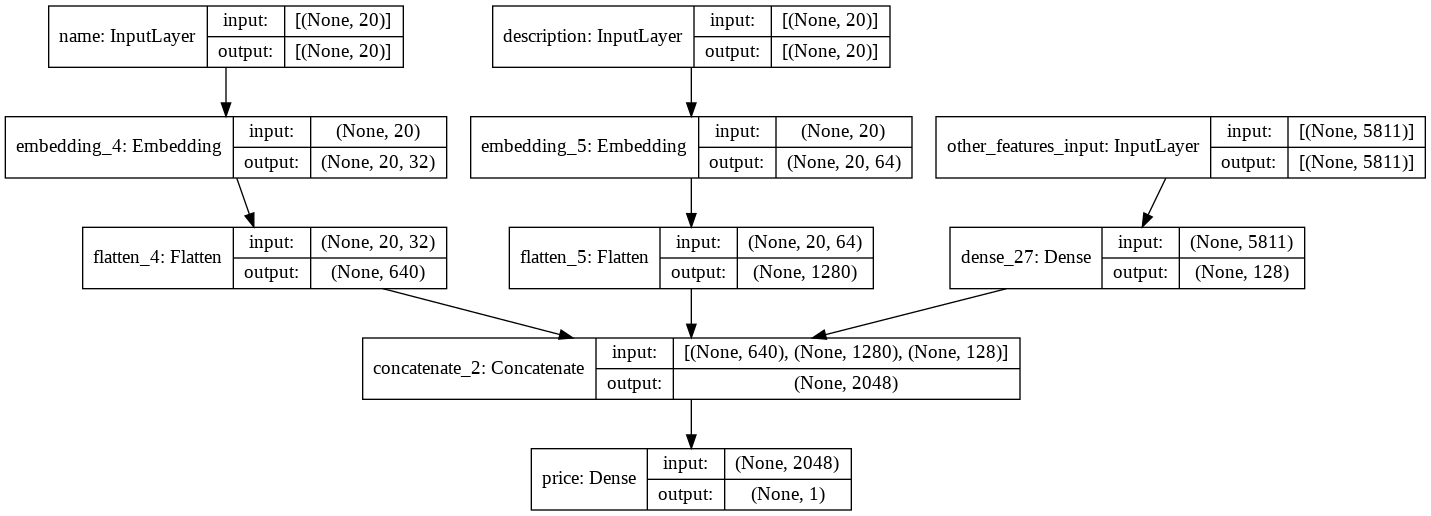

In [146]:
keras.utils.plot_model(embedding_model, "my_first_model_with_shape_info.png", show_shapes=True)

In [147]:
embedding_model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "price": keras.losses.MeanSquaredLogarithmicError(),
    },
    loss_weights=[1.0],
)

In [ ]:
names_data_validation

In [148]:
embedding_model.fit(
    {"name": names_data, "description": descriptions_data, "other_features_input": train_emb},
    {"price": label_train_emb},
    #validation_data=(names_data_validation, descriptions_data_validation, validation_emb, label_validation_emb),
    epochs=2,
    batch_size=256,
)

Epoch 1/2
4341/4341 [==============================] - 228s 52ms/step - loss: 0.0361
Epoch 2/2
4341/4341 [==============================] - 225s 51ms/step - loss: 0.0131


In [153]:
res = embedding_model.predict((names_data_test,descriptions_data_test,test_emb))

In [157]:
np.expm1(res)

array([[12.349235 ],
       [ 5.9210176],
       [56.149628 ],
       ...,
       [ 9.818287 ],
       [ 7.4205775],
       [14.806817 ]], dtype=float32)